In [30]:
import pandas as pd
import numpy as np
import networkx as nx
from node2vec import Node2Vec
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve, auc
from lightgbm import LGBMClassifier, early_stopping, log_evaluation

print("✅ Libraries imported successfully")

# --- Create synthetic data ---
n_samples = 5000
np.random.seed(42)

account_ids = [f"acc_{i}" for i in range(1, n_samples + 1)]
device_ids = [f"dev_{i}" for i in np.random.randint(1, 500, n_samples)]
amounts = np.random.exponential(scale=300, size=n_samples).astype(int)
countries = np.random.choice(["FR", "DE", "IT", "ES", "NL"], n_samples)
is_fraud = np.random.choice([0, 1], size=n_samples, p=[0.995, 0.005])

df = pd.DataFrame({
    "account_id": account_ids,
    "amount": amounts,
    "country": countries,
    "device_id": device_ids,
    "is_fraud": is_fraud
})

print(df.head())
print(f"✅ Synthetic dataframe created. Shape: {df.shape}")


✅ Libraries imported successfully
  account_id  amount country device_id  is_fraud
0      acc_1     277      NL   dev_103         0
1      acc_2     132      IT   dev_436         0
2      acc_3     313      IT   dev_349         0
3      acc_4      39      ES   dev_271         0
4      acc_5     658      FR   dev_107         0
✅ Synthetic dataframe created. Shape: (5000, 5)


In [31]:

# --- Create hybrid graph ---
G = nx.MultiDiGraph()
accounts = df["account_id"].unique()
devices = df["device_id"].unique()

G.add_nodes_from(accounts, node_type="account")
G.add_nodes_from(devices, node_type="device")

for _, row in df.iterrows():
    acc = row["account_id"]
    dev = row["device_id"]
    G.add_edge(acc, dev, edge_type="shared_device")
    G.add_edge(dev, acc, edge_type="shared_device")

print(f"✅ Hybrid graph created. Nodes: {G.number_of_nodes()}, Edges: {G.number_of_edges()}")

# --- Node2Vec embeddings ---
node2vec = Node2Vec(G, dimensions=32, walk_length=10, num_walks=50, workers=2)
model = node2vec.fit(window=5, min_count=1)
print("✅ Node2Vec embeddings generated")

embedding_vectors = []
account_ids_with_embed = []

for node in accounts:
    if node in model.wv:
        embedding_vectors.append(model.wv[node])
        account_ids_with_embed.append(node)

embeddings_df = pd.DataFrame(embedding_vectors)
embeddings_df["account_id"] = account_ids_with_embed

print(embeddings_df.head())
print(f"✅ Embeddings DataFrame created. Shape: {embeddings_df.shape}")


✅ Hybrid graph created. Nodes: 5499, Edges: 10000


Computing transition probabilities:   0%|          | 0/5499 [00:00<?, ?it/s]

Generating walks (CPU: 2): 100%|██████████| 25/25 [00:02<00:00, 11.20it/s]


✅ Node2Vec embeddings generated
          0         1         2         3         4         5         6  \
0  0.156045 -0.242993  1.602224 -0.374199 -0.009146  0.561833  0.837151   
1  0.429291 -1.231811  1.316049 -0.477171 -0.185571  1.123113 -0.084805   
2  1.763537 -0.859305  0.045681 -0.669814  0.196988  0.046498  0.058657   
3  0.084317 -0.343243  1.296637  0.941063  0.496592  0.115212 -0.679403   
4  0.617600 -1.148047  0.535561  0.725420 -0.172903 -0.263142  1.108935   

          7         8         9  ...        23        24        25        26  \
0  1.177600 -1.203222 -0.174235  ... -1.445737 -0.048690 -0.210056 -0.193633   
1  1.392009 -0.515888 -0.118332  ... -1.939148 -0.504945  0.094031 -0.022170   
2 -0.125017 -1.421219 -1.137473  ... -0.307359  0.849647  0.615678 -1.314952   
3  0.112208 -1.987234  0.025806  ... -1.505440  1.003640  0.350356 -0.612747   
4  1.116192 -1.429181 -0.997804  ... -1.003292 -0.310166 -0.950649 -1.051318   

         27        28        29     

In [32]:

# --- Merge embeddings ---
X_embed = df.merge(embeddings_df, on="account_id", how="left").fillna(0)
print(f"✅ Merged embeddings. Shape: {X_embed.shape}")



✅ Merged embeddings. Shape: (5000, 37)


In [33]:

# --- Prepare split and weights ---
X = X_fixed.drop(columns=["is_fraud"])
y = X_fixed["is_fraud"]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

neg = (y_train == 0).sum()
pos = (y_train == 1).sum()
scale_pos_weight = neg / pos

print(f"✅ Train shape: {X_train.shape}, Val shape: {X_val.shape}")
print(f"✅ scale_pos_weight: {scale_pos_weight:.2f}")

# --- Train LightGBM ---
params = {
    "objective": "binary",
    "scale_pos_weight": scale_pos_weight,
    "boosting_type": "gbdt",
    "learning_rate": 0.05,
    "num_leaves": 64,
}

clf = LGBMClassifier(**params, n_estimators=1000)

clf.fit(
    X_train,
    y_train,
    eval_set=[(X_val, y_val)],
    eval_metric="auc",
    callbacks=[
        early_stopping(stopping_rounds=30),
        log_evaluation(period=50)
    ]
)

print("✅ LightGBM model trained successfully!")


✅ Train shape: (4000, 35), Val shape: (1000, 35)
✅ scale_pos_weight: 249.00
[LightGBM] [Info] Number of positive: 16, number of negative: 3984
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000976 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8666
[LightGBM] [Info] Number of data points in the train set: 4000, number of used features: 35
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.004000 -> initscore=-5.517453
[LightGBM] [Info] Start training from score -5.517453
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 30 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[1]	valid_0's auc: 0.50804	valid_0's binary_logloss: 0.260474
✅ LightGBM model trained successfully!


In [34]:
# --- Encode categorical columns ---
X_fixed = X_embed.copy()
X_fixed = X_fixed.drop(columns=["account_id"])

for col in X_fixed.columns:
    if X_fixed[col].dtype == "object":
        le = LabelEncoder()
        X_fixed[col] = le.fit_transform(X_fixed[col].astype(str))

print(X_fixed.dtypes)
print("✅ All columns numeric and ready")

# --- Evaluate and set threshold ---
y_pred_probs = clf.predict_proba(X_val)[:, 1]

precision, recall, thresholds = precision_recall_curve(y_val, y_pred_probs)
pr_auc = auc(recall, precision)

f1_scores = 2 * (precision * recall) / (precision + recall + 1e-6)
best_idx = np.argmax(f1_scores)
chosen_threshold = thresholds[best_idx]

print(f"✅ Validation PR-AUC: {pr_auc:.4f}")
print(f"✅ Chosen threshold (best F1): {chosen_threshold:.4f}")

# --- Final predictions ---
final_preds = (y_pred_probs >= chosen_threshold).astype(int)

results_df = pd.DataFrame({
    "prob": y_pred_probs,
    "pred": final_preds,
    "true": y_val.values
})

print(results_df.head())
print("✅ Predictions completed and ready ✅")

amount         int64
country        int64
device_id      int64
is_fraud       int64
0            float32
1            float32
2            float32
3            float32
4            float32
5            float32
6            float32
7            float32
8            float32
9            float32
10           float32
11           float32
12           float32
13           float32
14           float32
15           float32
16           float32
17           float32
18           float32
19           float32
20           float32
21           float32
22           float32
23           float32
24           float32
25           float32
26           float32
27           float32
28           float32
29           float32
30           float32
31           float32
dtype: object
✅ All columns numeric and ready
✅ Validation PR-AUC: 0.0050
✅ Chosen threshold (best F1): 0.0038
       prob  pred  true
0  0.003805     0     0
1  0.003805     0     0
2  0.003805     0     0
3  0.003805     0     0
4  0.003805  

In [35]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score

# Compute metrics
precision_final = precision_score(y_val, final_preds)
recall_final = recall_score(y_val, final_preds)
f1_final = f1_score(y_val, final_preds)
auc_roc = roc_auc_score(y_val, y_pred_probs)

print(f"✅ Metrics on validation set:")
print(f"   Precision: {precision_final:.4f}")
print(f"   Recall:    {recall_final:.4f}")
print(f"   F1-score:  {f1_final:.4f}")
print(f"   AUC-PR:    {pr_auc:.4f}")
print(f"   AUC-ROC:   {auc_roc:.4f}")

✅ Metrics on validation set:
   Precision: 0.0089
   Recall:    0.2000
   F1-score:  0.0171
   AUC-PR:    0.0050
   AUC-ROC:   0.5080


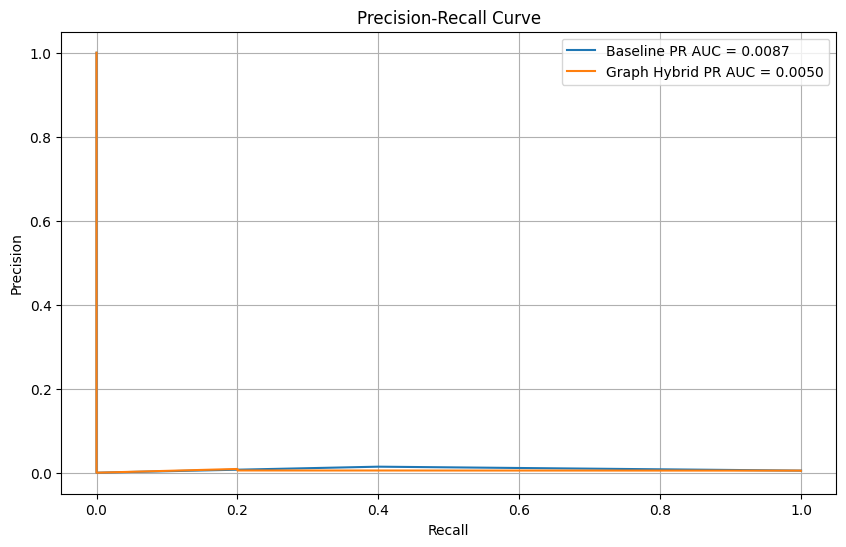

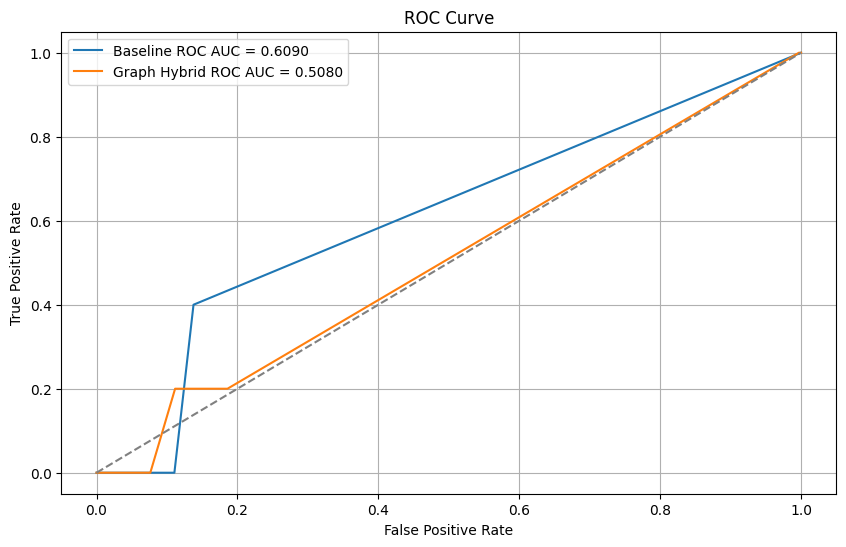

In [42]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve

# --- ROC curve for baseline ---
fpr_base, tpr_base, _ = roc_curve(y_val_base, y_pred_probs_base)
auc_roc_base = auc(fpr_base, tpr_base)

# --- ROC curve for hybrid (graph) ---
fpr_graph, tpr_graph, _ = roc_curve(y_val, y_pred_probs)
auc_roc_graph = auc(fpr_graph, tpr_graph)

# --- Plot PR Curve ---
plt.figure(figsize=(10, 6))
plt.plot(recall_base_vals, precision_base, label=f'Baseline PR AUC = {pr_auc_base:.4f}')
plt.plot(recall, precision, label=f'Graph Hybrid PR AUC = {pr_auc:.4f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid()
plt.show()

# --- Plot ROC Curve ---
plt.figure(figsize=(10, 6))
plt.plot(fpr_base, tpr_base, label=f'Baseline ROC AUC = {auc_roc_base:.4f}')
plt.plot(fpr_graph, tpr_graph, label=f'Graph Hybrid ROC AUC = {auc_roc_graph:.4f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid()
plt.show()

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score

precision_final = precision_score(y_val, final_preds)
recall_final = recall_score(y_val, final_preds)
f1_final = f1_score(y_val, final_preds)
auc_roc = roc_auc_score(y_val, y_pred_probs)

print(f"✅ Metrics on validation set:")
print(f"   Precision: {precision_final:.4f}")
print(f"   Recall:    {recall_final:.4f}")
print(f"   F1-score:  {f1_final:.4f}")
print(f"   AUC-PR:    {pr_auc:.4f}")
print(f"   AUC-ROC:   {auc_roc:.4f}")

In [ ]:
'''
Metric
Nodes, edges: Size of the graph.
Average degree: Typical connectivity.
Density: How tightly connected the graph is.
Components: Possible separate fraud rings.
Largest CC: Largest potential fraud network.: 
Degree dist.: Insight into hubs or super-connectors (often suspicious).

'''
# Basic stats
num_nodes = G.number_of_nodes()
num_edges = G.number_of_edges()
avg_degree = np.mean([deg for _, deg in G.degree()])
density = nx.density(G)
num_components = nx.number_weakly_connected_components(G) if G.is_directed() else nx.number_connected_components(G)

# Largest connected component size
largest_cc = max(nx.weakly_connected_components(G), key=len) if G.is_directed() else max(nx.connected_components(G), key=len)
largest_cc_size = len(largest_cc)

# Degree distribution stats
degrees = [deg for _, deg in G.degree()]
max_degree = np.max(degrees)
min_degree = np.min(degrees)

# Print
print("✅ Graph stats:")
print(f"   Nodes: {num_nodes}")
print(f"   Edges: {num_edges}")
print(f"   Average degree: {avg_degree:.2f}")
print(f"   Density: {density:.6f}")
print(f"   Connected components: {num_components}")
print(f"   Largest component size: {largest_cc_size}")
print(f"   Max degree: {max_degree}")
print(f"   Min degree: {min_degree}")

✅ Graph stats:
   Nodes: 5499
   Edges: 10000
   Average degree: 3.64
   Density: 0.000331
   Connected components: 499
   Largest component size: 20
   Max degree: 38
   Min degree: 2


### SHAPE Explanations

/Users/firaterman/Documents/fer/berserk3/lib/python3.12/site-packages/shap/explainers/_tree.py:583: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(
/var/folders/dr/83m5p3m94s7gmtrc3_97lxvc0000gn/T/ipykernel_6330/4208444317.py:12: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_val, max_display=15)


✅ SHAP values computed


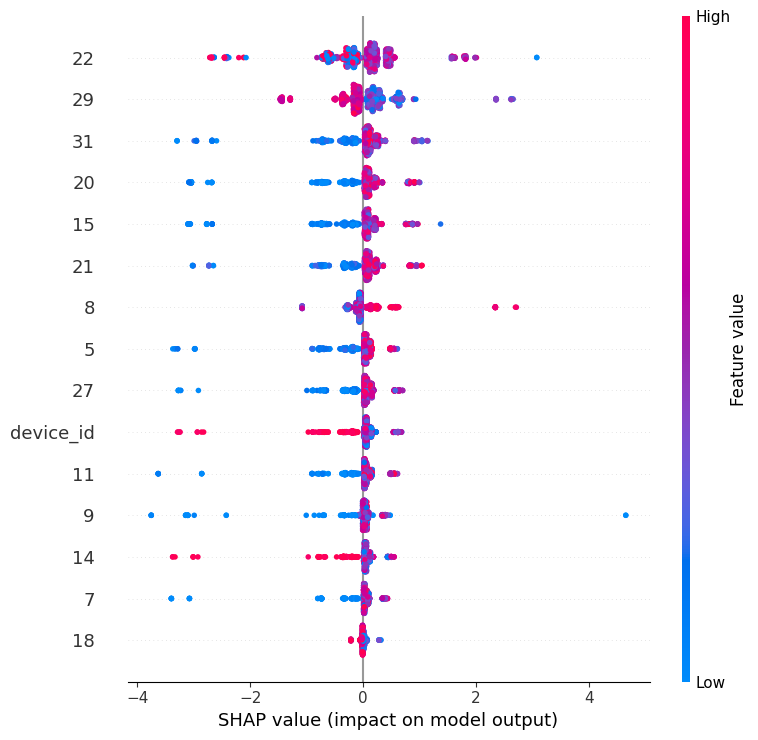

In [41]:
import shap

# --- Create SHAP explainer for LightGBM model ---
explainer = shap.TreeExplainer(clf)

# --- Compute SHAP values on validation set ---
shap_values = explainer.shap_values(X_val)

print("✅ SHAP values computed")

# --- Summary plot (global feature importance) ---
shap.summary_plot(shap_values, X_val, max_display=15)

# --- Optional: force plot for one example (interactive if using Jupyter Notebook) ---
sample_idx = 0
shap.initjs()
shap.force_plot(
    explainer.expected_value,
    shap_values[sample_idx, :],
    X_val.iloc[sample_idx, :]
)

### Here’s a single, consolidated cell that compares the baseline model (without graph) to the hybrid model (with graph embeddings) in one go.

In [37]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve, auc, precision_score, recall_score, f1_score

# --- Baseline data prep (without graph) ---
df_baseline = df.copy()

for col in ["country", "device_id"]:
    le = LabelEncoder()
    df_baseline[col] = le.fit_transform(df_baseline[col].astype(str))

df_baseline = df_baseline.drop(columns=["account_id"])

X_base = df_baseline.drop(columns=["is_fraud"])
y_base = df_baseline["is_fraud"]

X_train_base, X_val_base, y_train_base, y_val_base = train_test_split(X_base, y_base, test_size=0.2, random_state=42)

neg_base = (y_train_base == 0).sum()
pos_base = (y_train_base == 1).sum()
scale_pos_weight_base = neg_base / pos_base

params_base = {
    "objective": "binary",
    "scale_pos_weight": scale_pos_weight_base,
    "boosting_type": "gbdt",
    "learning_rate": 0.05,
    "num_leaves": 64,
}

clf_base = LGBMClassifier(**params_base, n_estimators=1000)

clf_base.fit(
    X_train_base,
    y_train_base,
    eval_set=[(X_val_base, y_val_base)],
    eval_metric="auc",
    callbacks=[
        early_stopping(stopping_rounds=30),
        log_evaluation(period=50)
    ]
)

# --- Baseline predictions ---
y_pred_probs_base = clf_base.predict_proba(X_val_base)[:, 1]
precision_base, recall_base_vals, thresholds_base = precision_recall_curve(y_val_base, y_pred_probs_base)
pr_auc_base = auc(recall_base_vals, precision_base)

f1_scores_base = 2 * (precision_base * recall_base_vals) / (precision_base + recall_base_vals + 1e-6)
best_idx_base = np.argmax(f1_scores_base)
threshold_base = thresholds_base[best_idx_base]
final_preds_base = (y_pred_probs_base >= threshold_base).astype(int)

precision_final_base = precision_score(y_val_base, final_preds_base)
recall_final_base = recall_score(y_val_base, final_preds_base)
f1_final_base = f1_score(y_val_base, final_preds_base)

fraud_caught_base = (final_preds_base & (y_val_base == 1)).sum()
fraud_caught_graph = (final_preds & (y_val == 1)).sum()

# --- Print summary ---
print("✅ Comparison of baseline vs graph hybrid model:")
print(f"--- Baseline (no graph) ---")
print(f"   Precision: {precision_final_base:.4f}")
print(f"   Recall:    {recall_final_base:.4f}")
print(f"   F1-score:  {f1_final_base:.4f}")
print(f"   AUC-PR:    {pr_auc_base:.4f}")
print(f"   Fraud transactions caught: {fraud_caught_base}")

print(f"--- Graph Hybrid ---")
print(f"   Precision: {precision_final:.4f}")
print(f"   Recall:    {recall_final:.4f}")
print(f"   F1-score:  {f1_final:.4f}")
print(f"   AUC-PR:    {pr_auc:.4f}")
print(f"   Fraud transactions caught: {fraud_caught_graph}")

if fraud_caught_graph > fraud_caught_base:
    print("✅ Graph hybrid model caught more fraud transactions! 🚀")
else:
    print("⚠️ Graph hybrid model did not catch more frauds — check features and embeddings.")

[LightGBM] [Info] Number of positive: 16, number of negative: 3984
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000216 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 506
[LightGBM] [Info] Number of data points in the train set: 4000, number of used features: 3
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.004000 -> initscore=-5.517453
[LightGBM] [Info] Start training from score -5.517453
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[1]	valid_0's auc: 0.609045	valid_0's binary_logloss: 0.564619
✅ Comparison of baseline vs graph hybrid model:
--- Baseline (no graph) ---
   Precision: 0.0144
   Recall:    0.4000
   F1-score:  0.0278
   AUC-PR:    0.0087
   Fraud transactions caught: 2
--- Graph Hybrid ---
   Precision: 0.0089
   Recall:    0.2000
   F1-score:  0.0171
   